In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action='ignore')
from scipy.signal import butter, lfilter, freqz
# from torch import nn, optim
import sqlite3, os
import math
import random
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import animation
import matplotlib

In [ ]:

path = '/content/drive/MyDrive/self_data/'

# Filter requirements.
order = 4
fs = 50.0  # sample rate, Hz
cutoff = 5.0  # desired cutoff frequency of the filter, Hz


# From??????
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
def printer(df, min_max=True, range=[0,3000], *args):
    idx = {}
    if min_max:
        x = df.drop(['activity','person'],axis=1).astype('float64')
        k = (x - x.min()) / (x.max() - x.min())
        for w in args:
            plt.plot(k[w],label=w)
            idx[w] = df[w][df[w] == df[w].max()].index.values
        plt.title(f'person:{df.person[0]}  ,  activity:{df.activity[0]}')
        plt.xlim(range)
        plt.legend()
        plt.show()
        for w in idx:
            print(f'{w} : {idx[w]}')
    else:
        for w in args:
            plt.plot(df[w],label=w)
        plt.title(df.activity[0])
        plt.xlim(range)
        plt.legend()
        plt.show()

In [ ]:
def preprocess2(df, range, check_list):
    df_list = []
    rol_val = 50
    for trial_df in df:
        if len(trial_df) == 0:
            continue
        trial_df.reset_index(inplace=True)
        tempdf = pd.DataFrame()
        tempdf['ax'], tempdf['ay'], tempdf['az'] = trial_df['ADXL_x'], trial_df['ADXL_y'], trial_df['ADXL_z']
        tempdf = tempdf.reset_index(drop=True)
        tempdf['fx'] = pd.Series(butter_lowpass_filter(trial_df['ADXL_x'], cutoff, fs, order))
        tempdf['fy'] = pd.Series(butter_lowpass_filter(trial_df['ADXL_y'], cutoff, fs, order))
        tempdf['fz'] = pd.Series(butter_lowpass_filter(trial_df['ADXL_z'], cutoff, fs, order))
        tempdf['vs'] = np.sqrt(tempdf['ax'] ** 2 + tempdf['ay'] ** 2 + tempdf['az'] ** 2)
        tempdf['vm2'] =np.sqrt(tempdf['fx'] ** 2 + tempdf['fy'] ** 2 + tempdf['fz'] ** 2)

        tempdf['bx'] = tempdf['fx'].diff()
        tempdf['by'] = tempdf['fy'].diff()
        tempdf['bz'] = tempdf['fz'].diff()
        tempdf['diff_sum'] = np.sqrt(tempdf['bx'] ** 2 + tempdf['by'] ** 2 + tempdf['bz'] ** 2)
        tempdf['activity'] = trial_df['activity']
        tempdf['person'] = trial_df['person']

        tempdf = tempdf.reset_index(drop=True)
        trial_df = trial_df.reset_index(drop=True)
        tempdf['gx'], tempdf['gy'], tempdf['gz'] = trial_df['ITG_x'], trial_df['ITG_y'], trial_df['ITG_z']
        tempdf['g_fx'] = pd.Series(butter_lowpass_filter(tempdf['gx'], cutoff, fs, order))
        tempdf['g_fy'] = pd.Series(butter_lowpass_filter(tempdf['gy'], cutoff, fs, order))
        tempdf['g_fz'] = pd.Series(butter_lowpass_filter(tempdf['gz'], cutoff, fs, order))
        tempdf['g_sum'] = np.sqrt(tempdf['g_fx'] ** 2 + tempdf['g_fy'] ** 2 + tempdf['g_fz'] ** 2)


        #Rolling standard deviations
        tempdf['bx_std'] = tempdf['bx'].rolling(rol_val,min_periods = 1).std()
        tempdf['by_std'] = tempdf['by'].rolling(rol_val,min_periods = 1).std()
        tempdf['bz_std'] = tempdf['bz'].rolling(rol_val,min_periods = 1).std()
        tempdf['fx_std'] = tempdf['fx'].rolling(rol_val,min_periods = 1).std()
        tempdf['fy_std'] = tempdf['fy'].rolling(rol_val,min_periods = 1).std()
        tempdf['fz_std'] = tempdf['fz'].rolling(rol_val,min_periods = 1).std()
        tempdf['gx_std'] = tempdf['gx'].rolling(rol_val,min_periods = 1).std()
        tempdf['gy_std'] = tempdf['gy'].rolling(rol_val,min_periods = 1).std()
        tempdf['gz_std'] = tempdf['gz'].rolling(rol_val,min_periods = 1).std()

        # had to make versions of this to put into sliding window, will change once I
        # confirm they're the same as the others below
        #C8
        tempdf['horiz_std_mag9'] = np.sqrt(tempdf['fx_std'] ** 2 + tempdf['fz_std'] ** 2)
        #C2
        tempdf['horiz_vector_mag9'] = np.sqrt(tempdf['fx'] ** 2 + tempdf['fz'] ** 2)
        tempdf['std_mag9'] = np.sqrt(tempdf['fx_std'] ** 2 + tempdf['fy_std'] ** 2 + tempdf['fz_std'] ** 2)
        #C9
        tempdf['horiz_std_mag2'] = np.sqrt(tempdf['bx_std'] ** 2 + tempdf['bz_std'] ** 2)
        tempdf['gyro_horiz_std_mag'] = np.sqrt(tempdf['gx_std'] ** 2 + tempdf['gz_std'] ** 2)
        tempdf['gyro_vector_mag'] = np.sqrt(tempdf['gx'] ** 2 + tempdf['gy'] ** 2 + tempdf['gz'] ** 2)
        tempdf['gyro_horiz_mag'] = np.sqrt(tempdf['gx'] ** 2 + tempdf['gz'] ** 2)
        # C2
        tempdf['horiz_mag'] = np.sqrt(tempdf['fx'] ** 2 + tempdf['fz'] ** 2)

        tempdf = tempdf.loc[:,check_list]
        tempdf = (tempdf - tempdf.min()) / (tempdf.max() - tempdf.min())
        k = tempdf['vm2'].idxmax()
        tempdf['label'] = 0
        tempdf['label'].loc[k - range : k] = 1
        tempdf = tempdf.loc[:k]
        df_list.append(tempdf.fillna(0))
    return df_list

In [ ]:
person = ['data1','data3','data5','data7','data9','data11','data13','data15','data17','data19','data21','data23']
subjectList = []
count = 0
count2 = 0
for t in range(1,25):
    a = pd.read_csv(path + f'data{t}.csv',names=['ADXL_x', 'ADXL_y', 'ADXL_z', 'ITG_x', 'ITG_y','ITG_z','seq'])
    if count == 6:
        count = 0
    if count < 2:
        a['person'] = 'SA01'
    elif count < 4:
        a['person'] = 'SA02'
    elif count < 6:
        a['person'] = 'SA03'
    count += 1
    a['activity'] = str(count2 // 6 + 1)
    count2 += 1
    df = a[['ADXL_x', 'ADXL_y', 'ADXL_z', 'ITG_x', 'ITG_y', 'ITG_z','person','activity']]
    df.reset_index(inplace=True)
    df = df.drop(['level_0','level_1'],axis=1)
#     df['ADXL_x'] *= (32/8192)
#     df['ADXL_y'] *= (32/8192)
#     df['ADXL_z'] *= (32/8192)
    subjectList.append(df)

In [ ]:
df_list = preprocess2(subjectList, 50, ['g_sum','diff_sum','vm2'])

In [ ]:
x = []
y = []
windowsize = 20
for df in df_list:
    for i in range(len(df) - windowsize):
        df_x = df.drop('label',axis=1).iloc[i : i+ windowsize]
        df_y = df['label'].iloc[i+windowsize]
        x.append(df_x)
        y.append(df_y)
x = np.array(x)
y = np.array(y)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state = 0)

In [ ]:
model = tf.keras.models.Sequential([
    # 1차원 feature map 생성
#     tf.keras.layers.Conv1D(filters=32, kernel_size=5,
#            padding="causal",
#            activation="relu",dff
#            input_shape=[WINDOW_SIZE, 4]),
    # LSTM
    tf.keras.layers.LSTM(128,input_shape=[windowsize, 3], activation='tanh', return_sequences=True),
    tf.keras.layers.LSTM(64,  return_sequences=True,dropout=0.2 ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics='accuracy')
early_stop = EarlyStopping(monitor='val_loss', patience=15)
filename = os.path.join(path + 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=32,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/100
114/117 [============================>.] - ETA: 0s - loss: 0.4084 - accuracy: 0.8561
Epoch 00001: val_loss improved from inf to 0.33663, saving model to /content/drive/MyDrive/self_data/tmp_checkpoint.h5
117/117 [==============================] - 9s 22ms/step - loss: 0.4038 - accuracy: 0.8581 - val_loss: 0.3366 - val_accuracy: 0.8853
Epoch 2/100
116/117 [============================>.] - ETA: 0s - loss: 0.2940 - accuracy: 0.8960
Epoch 00002: val_loss improved from 0.33663 to 0.24276, saving model to /content/drive/MyDrive/self_data/tmp_checkpoint.h5
117/117 [==============================] - 1s 8ms/step - loss: 0.2940 - accuracy: 0.8962 - val_loss: 0.2428 - val_accuracy: 0.9175
Epoch 3/100
109/117 [==========================>...] - ETA: 0s - loss: 0.2640 - accuracy: 0.9057
Epoch 00003: val_loss improved from 0.24276 to 0.22447, saving model to /content/drive/MyDrive/self_data/tmp_checkpoint.h5
117/117 [==============================] - 1s 8ms/step - loss: 0.2635 - accuracy:

In [ ]:
score = model.evaluate(x_train,y_train)
print(score[1])
print(score[0])
# p = pd.DataFrame(pre.round())
# p
# x = pd.DataFrame(y_train)
# t = pd.concat([p,x],axis=1)
# (t.iloc[:,1] + t.iloc[:,0]).value_counts()

117/117 [==============================] - 0s 4ms/step - loss: 0.0625 - accuracy: 0.9791
0.9790772795677185
0.06249145045876503


In [ ]:
path2 = '/content/drive/MyDrive/self_data/우리가찍은거tosisfall/'

In [ ]:
os.listdir(path2)

['F02_SA01_R03.csv',
 'F02_SA01_R02.csv',
 'F01_SA01_R01.csv',
 'F02_SA01_R01.csv',
 'F04_SA01_R02.csv',
 'F04_SA01_R01.csv',
 'F01_SA01_R03.csv',
 'F03_SA01_R02.csv',
 'F03_SA01_R03.csv',
 'F01_SA01_R02.csv',
 'F04_SA01_R03.csv',
 'F03_SA01_R01.csv']

In [ ]:
names = os.listdir(path2)
sublist = []
for name in names:
    t = pd.read_csv(path2 + name)
    t.columns = ['time', 'ADXL_x', 'ADXL_y', 'ADXL_z', 'ITG_x', 'ITG_y','ITG_z', 'vm','gm']
    t['activity'] = name[:3]
    t['person'] = 'SA01'
    t.drop(['vm','gm'],axis=1)
    sublist.append(t)

In [ ]:
df_list = preprocess2(sublist, 50,['g_sum','diff_sum','vm2'] )

In [ ]:
x = []
y = []
for df in df_list:
    for i in range(len(df) - windowsize):
        df_x = df.drop('label',axis=1).iloc[i : i+ windowsize]
        df_y = df['label'].iloc[i+windowsize]
        x.append(df_x)
        y.append(df_y)
x = np.array(x)
y = np.array(y)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state = 0)

In [ ]:
score = model.evaluate(x_train,y_train)
print(score[1])
print(score[0])

42/42 [==============================] - 0s 4ms/step - loss: 0.7211 - accuracy: 0.8720
0.8719696998596191
0.7210729122161865


In [ ]:

trial_df = sublist[5].copy()

rol_val = 50

trial_df.reset_index(inplace=True)
tempdf = pd.DataFrame()
tempdf['ax'], tempdf['ay'], tempdf['az'] = trial_df['ADXL_x'], trial_df['ADXL_y'], trial_df['ADXL_z']
tempdf['fx'] = pd.Series(butter_lowpass_filter(trial_df['ADXL_x'], cutoff, fs, order))
tempdf['fy'] = pd.Series(butter_lowpass_filter(trial_df['ADXL_y'], cutoff, fs, order))
tempdf['fz'] = pd.Series(butter_lowpass_filter(trial_df['ADXL_z'], cutoff, fs, order))
tempdf['vs'] = np.sqrt(tempdf['ax'] ** 2 + tempdf['ay'] ** 2 + tempdf['az'] ** 2)
tempdf['vm2'] =np.sqrt(tempdf['fx'] ** 2 + tempdf['fy'] ** 2 + tempdf['fz'] ** 2)

tempdf['bx'] = tempdf['fx'].diff()
tempdf['by'] = tempdf['fy'].diff()
tempdf['bz'] = tempdf['fz'].diff()
tempdf['diff_sum'] = np.sqrt(tempdf['bx'] ** 2 + tempdf['by'] ** 2 + tempdf['bz'] ** 2)
tempdf['activity'] = trial_df['activity']
tempdf['person'] = trial_df['person']

tempdf['gx'], tempdf['gy'], tempdf['gz'] = trial_df['ITG_x'], trial_df['ITG_y'], trial_df['ITG_z']
tempdf['g_fx'] = pd.Series(butter_lowpass_filter(tempdf['gx'], cutoff, fs, order))
tempdf['g_fy'] = pd.Series(butter_lowpass_filter(tempdf['gy'], cutoff, fs, order))
tempdf['g_fz'] = pd.Series(butter_lowpass_filter(tempdf['gz'], cutoff, fs, order))
tempdf['g_sum'] = np.sqrt(tempdf['g_fx'] ** 2 + tempdf['g_fy'] ** 2 + tempdf['g_fz'] ** 2)

#Rolling standard deviations
tempdf['bx_std'] = tempdf['bx'].rolling(rol_val,min_periods = 1).std()
tempdf['by_std'] = tempdf['by'].rolling(rol_val,min_periods = 1).std()
tempdf['bz_std'] = tempdf['bz'].rolling(rol_val,min_periods = 1).std()
tempdf['fx_std'] = tempdf['fx'].rolling(rol_val,min_periods = 1).std()
tempdf['fy_std'] = tempdf['fy'].rolling(rol_val,min_periods = 1).std()
tempdf['fz_std'] = tempdf['fz'].rolling(rol_val,min_periods = 1).std()
tempdf['gx_std'] = tempdf['gx'].rolling(rol_val,min_periods = 1).std()
tempdf['gy_std'] = tempdf['gy'].rolling(rol_val,min_periods = 1).std()
tempdf['gz_std'] = tempdf['gz'].rolling(rol_val,min_periods = 1).std()

# had to make versions of this to put into sliding window, will change once I
# confirm they're the same as the others below
#C8
tempdf['horiz_std_mag9'] = np.sqrt(tempdf['fx_std'] ** 2 + tempdf['fz_std'] ** 2)
#C2
tempdf['horiz_vector_mag9'] = np.sqrt(tempdf['fx'] ** 2 + tempdf['fz'] ** 2)
tempdf['std_mag9'] = np.sqrt(tempdf['fx_std'] ** 2 + tempdf['fy_std'] ** 2 + tempdf['fz_std'] ** 2)
#C9
tempdf['horiz_std_mag2'] = np.sqrt(tempdf['bx_std'] ** 2 + tempdf['bz_std'] ** 2)
tempdf['gyro_horiz_std_mag'] = np.sqrt(tempdf['gx_std'] ** 2 + tempdf['gz_std'] ** 2)
tempdf['gyro_vector_mag'] = np.sqrt(tempdf['gx'] ** 2 + tempdf['gy'] ** 2 + tempdf['gz'] ** 2)
tempdf['gyro_horiz_mag'] = np.sqrt(tempdf['gx'] ** 2 + tempdf['gz'] ** 2)
# C2
tempdf['horiz_mag'] = np.sqrt(tempdf['fx'] ** 2 + tempdf['fz'] ** 2)

tempdf = tempdf.loc[:,['g_sum','diff_sum','vm2']]
tempdf = (tempdf - tempdf.min()) / (tempdf.max() - tempdf.min())
k = tempdf['vm2'].idxmax()
tempdf = tempdf.fillna(0)
tempdf['label'] = 0
tempdf['label'].loc[k - 40 : k] = 1
real_df = tempdf.copy()
tempdf = tempdf.loc[:k]


In [ ]:
df = tempdf
x = []
y = []
for i in range(len(df) - 15):
    df_x = df.drop('label',axis=1).iloc[i : i+ 15]
    df_y = df['label'].iloc[i+15]
    x.append(df_x)
    y.append(df_y)
x = np.array(x)
y = np.array(y)

In [ ]:
model.evaluate(x,y)

6/6 [==============================] - 0s 4ms/step - loss: 0.0117 - accuracy: 1.0000


[0.011671802029013634, 1.0]

In [ ]:
zeros = np.zeros((15,1))
pre = model.predict(x)
pre = pre.round()
conca = np.concatenate((zeros, pre), axis=0)

In [ ]:
k = real_df

In [ ]:
t = len(k) - len(conca)
ones = np.ones((t,1))
conca = np.concatenate((conca, ones), axis=0)
pre_list = conca.reshape(-1,).tolist()


In [ ]:
zeroy= np.zeros((15,))

In [ ]:
np.where(conca == 1)

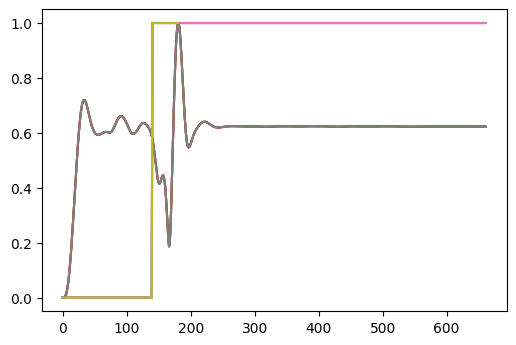

In [ ]:
plt.plot(pre_list)
plt.plot(k.vm2)
plt.plot(np.concatenate((zeroy, y),axis=0).tolist())
plt.show()

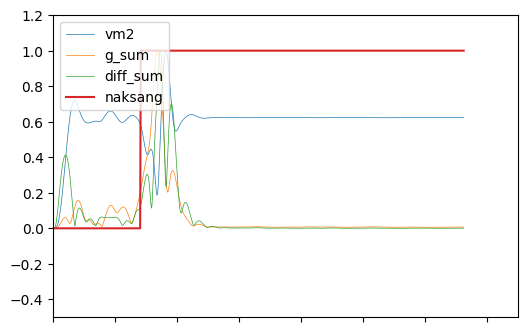

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 15), ylim=(-0.5, 1.2))
line, = ax.plot([], [], lw=0.5)
line2, = ax.plot([],[], lw=0.5)
line3, = ax.plot([],[], lw=0.5)
line4, = ax.plot([],[], lw=1.5)
ax.legend([line, line2,line3,line4], ['vm2', 'g_sum','diff_sum','naksang'], loc='upper left')
plt.setp( ax.get_xticklabels(), visible=False)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])

    return line, line2, line3, line4,
# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(662/50, 0, 662)
    line.set_data(x[:i], k['vm2'][:i][::-1])
    line2.set_data(x[:i], k['g_sum'][:i][::-1])
    line3.set_data(x[:i], k['diff_sum'][:i][::-1])
    line4.set_data(x[:i], pre_list[:i][::-1])

    return line, line2, line3, line4,
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=662, interval=20, blit=True)


anim.save('basic_animation.mp4', fps=50, extra_args=['-vcodec', 'libx264'])
# writergif = animation.PillowWriter(fps=50)
# anim.save("kkc.gif", writer=writergif)
# anim.save('exAnimation.gif', writer='writergif', fps=50, dpi=100)
plt.show()

In [ ]:
x = []
y = []
for df in df_list:
    for i in range(len(df) - 15):
        df_x = df.drop('label',axis=1).iloc[i : i+ 15]
        df_y = df['label'].iloc[i+15]
        x.append(df_x)
        y.append(df_y)
x = np.array(x)
y = np.array(y)
model.evaluate(x,y)